# OCT2017 - Traditional Baseline: Random Forest

In [1]:
# ================================================
# OCT2017 - Traditional Baseline: Random Forest
# Features: HOG + LBP(8,1) + LBP(16,2) + GLCM + intensity histogram
# Model: RandomForestClassifier (fast, robust, progress shown)
# Saves: model, metrics CSV, confusion matrix JSON, cached .npy features
# ================================================
import os, glob, time, platform, warnings, pickle, csv, json
from pathlib import PureWindowsPath
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from tqdm import tqdm

# --- Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.preprocessing import label_binarize

# --- Skimage features
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

In [2]:


# -------------------------------
# WSL-safe path helper
# -------------------------------
def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"


In [3]:

# -------------------------------
# Config
# -------------------------------
# >>> UPDATE THIS TO YOUR DATASET ROOT <<<
BASE_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15"
BASE_DIR = win_to_wsl_path(BASE_DIR)

IMG_SIZE      = (128, 128)
CLASSES       = ["CNV","DME","DRUSEN","NORMAL"]
RANDOM_SEED   = 42
OUT_DIR       = "traditional_rf"
CACHE_DIR     = os.path.join(OUT_DIR, "cache")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

# Feature cache flags
SAVE_FEATURES      = True
LOAD_IF_AVAILABLE  = True

# RandomForest hyperparams 
RF_TREES      = 400           # increase for small boost, slower
RF_MAX_DEPTH  = None          # None = fully grown (good baseline)
RF_N_JOBS     = -1            # use all cores
RF_VERBOSE    = 2             # show training progress (trees built)
RF_CLASS_WT   = "balanced_subsample"  # handle class imbalance


In [4]:

# -------------------------------
# Feature extractors
# -------------------------------
def extract_hog(img128):
    return hog(img128,
               pixels_per_cell=(16,16),
               cells_per_block=(2,2),
               orientations=9,
               block_norm="L2-Hys",
               transform_sqrt=True,
               feature_vector=True).astype(np.float32)

def extract_lbp_hist(img128, P=8, R=1):
    lbp = local_binary_pattern(img128, P=P, R=R, method="uniform")
    n_bins = int(P + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def extract_glcm_stats(img128):
    # quantize to 32 levels to stabilize GLCM
    img8 = cv2.normalize(img128, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    imgQ = (img8 // 8).astype(np.uint8)  # 0..31
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(imgQ, distances=distances, angles=angles,
                        levels=32, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","ASM","energy","correlation"]
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)    # (len(distances), len(angles))
        feats.append(vals.mean()); feats.append(vals.std())
    return np.array(feats, dtype=np.float32)

def extract_intensity_hist(img128, bins=32):
    hist = cv2.calcHist([img128],[0],None,[bins],[0,256]).ravel()
    hist = hist / (hist.sum() + 1e-8)
    return hist.astype(np.float32)

def extract_features_single(gray128):
    return np.concatenate([
        extract_hog(gray128),
        extract_lbp_hist(gray128, P=8,  R=1),
        extract_lbp_hist(gray128, P=16, R=2),
        extract_glcm_stats(gray128),
        extract_intensity_hist(gray128, bins=32),
    ], axis=0)


In [5]:

# -------------------------------
# Data loading + cache
# -------------------------------
def list_images(root):
    items = []
    for c in CLASSES:
        p = os.path.join(root, c)
        exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
        files = []
        for e in exts: files += glob.glob(os.path.join(p, e))
        for f in files: items.append((f, c))
    return items

def load_split(phase_dir, cache_prefix):
    X_path = os.path.join(CACHE_DIR, f"{cache_prefix}_X.npy")
    y_path = os.path.join(CACHE_DIR, f"{cache_prefix}_y.npy")
    p_path = os.path.join(CACHE_DIR, f"{cache_prefix}_paths.npy")

    if LOAD_IF_AVAILABLE and os.path.isfile(X_path) and os.path.isfile(y_path) and os.path.isfile(p_path):
        X = np.load(X_path, mmap_mode=None)
        y = np.load(y_path, mmap_mode=None)
        paths = np.load(p_path, allow_pickle=True).tolist()
        return X, y, paths

    pairs = list_images(phase_dir)
    X, y, paths = [], [], []
    for fp, label in tqdm(pairs, desc=f"Loading {phase_dir}", total=len(pairs)):
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        X.append(extract_features_single(img))
        y.append(CLASSES.index(label))
        paths.append(fp)

    if len(X) == 0:
        raise RuntimeError(f"No images loaded from {phase_dir}. Check paths.")

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)

    if SAVE_FEATURES:
        np.save(X_path, X); np.save(y_path, y); np.save(p_path, np.array(paths, dtype=object))
    return X, y, paths


In [6]:

# -------------------------------
# Scan & load
# -------------------------------
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

print("[INFO] Scanning dataset...")
for split in ("train","val","test"):
    split_dir = os.path.join(BASE_DIR, split)
    present = [c for c in CLASSES if os.path.isdir(os.path.join(split_dir, c))]
    print(f"  {split}: {split_dir} | classes found: {present}")

t0 = time.time()
X_train, y_train, _ = load_split(train_dir, "train")
X_val,   y_val,   _ = load_split(val_dir,   "val")
X_test,  y_test,  _ = load_split(test_dir,  "test")
print(f"[INFO] Shapes -> train {X_train.shape}, val {X_val.shape}, test {X_test.shape}")
print(f"[TIMER] Feature extraction: {time.time()-t0:.1f}s")

# Merge train+val for final training
X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

[INFO] Scanning dataset...
  train: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\train | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
  val: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\val | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
  test: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\test | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\train: 100%|██████████| 59126/59126 [13:47<00:00, 71.41it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\val: 100%|██████████| 12670/12670 [02:59<00:00, 70.56it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\test: 100%|██████████| 12669/12669 [03:11<00:00, 66.10it/s]


[INFO] Shapes -> train (59126, 1836), val (12670, 1836), test (12669, 1836)
[TIMER] Feature extraction: 1235.7s


In [7]:


# -------------------------------
# Train RandomForest (with progress)
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=RF_TREES,
    max_depth=RF_MAX_DEPTH,
    class_weight=RF_CLASS_WT,
    n_jobs=RF_N_JOBS,
    random_state=RANDOM_SEED,
    verbose=RF_VERBOSE
)

print("\n==== Training RandomForest ====")
t1 = time.time()
rf.fit(X_tr, y_tr)
train_time = time.time() - t1
print(f"[INFO] Training time: {train_time:.1f}s")


==== Training RandomForest ====


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 9 of 400
building tree 5 of 400
building tree 4 of 400
building tree 3 of 400
building tree 11 of 400
building tree 12 of 400
building tree 8 of 400
building tree 10 of 400
building tree 1 of 400
building tree 6 of 400
building tree 2 of 400
building tree 7 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.6s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min


building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.1min


building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.0min finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    1.5s finished



[RESULT] Test Acc=0.8368 | Macro-F1=0.7370

Classification report:
               precision    recall  f1-score   support

         CNV     0.8415    0.9710    0.9016      5617
         DME     0.9010    0.6544    0.7582      1739
      DRUSEN     0.8315    0.2897    0.4297      1329
      NORMAL     0.8124    0.9099    0.8584      3984

    accuracy                         0.8368     12669
   macro avg     0.8466    0.7062    0.7370     12669
weighted avg     0.8395    0.8368    0.8188     12669

Confusion matrix:
 [[5454    3   52  108]
 [ 287 1138    6  308]
 [ 523    0  385  421]
 [ 217  122   20 3625]]


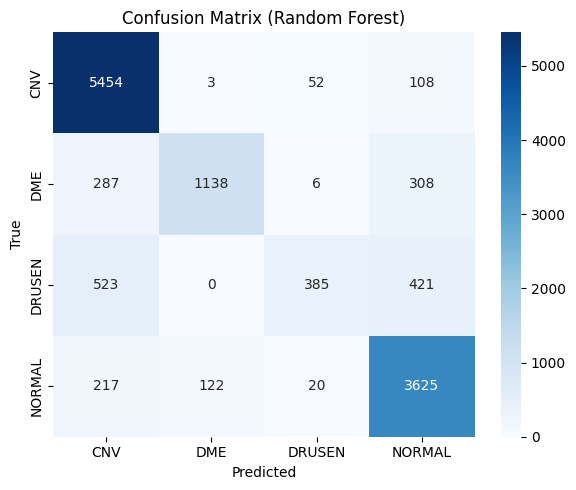

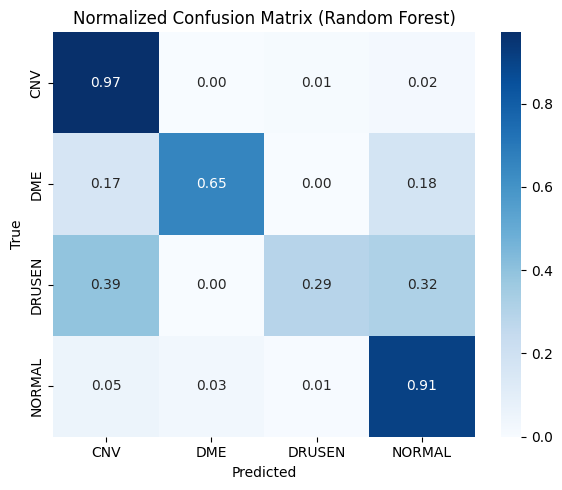

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    1.4s finished


ROC-AUC (OvR): 0.9610


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# -------------------------------
# Evaluate
# -------------------------------
y_pred = rf.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
f1m    = f1_score(y_test, y_pred, average="macro")
print(f"\n[RESULT] Test Acc={acc:.4f} | Macro-F1={f1m:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=CLASSES, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ---- Plot Raw Confusion Matrix ----
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

# ---- Plot Normalized Confusion Matrix ----
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

# ROC-AUC (OvR)
auc_ovr = None
try:
    y_score = rf.predict_proba(X_test)
    y_bin   = label_binarize(y_test, classes=np.arange(len(CLASSES)))
    auc_ovr = roc_auc_score(y_bin, y_score, multi_class="ovr")
except Exception:
    pass
print(f"ROC-AUC (OvR): {auc_ovr:.4f}" if auc_ovr is not None else "ROC-AUC (OvR): N/A")


In [9]:


# -------------------------------
# Save artefacts
# -------------------------------
model_path = os.path.join(OUT_DIR, "random_forest.pkl")
with open(model_path, "wb") as f:
    pickle.dump(rf, f)
print(f"[SAVED] {model_path}")

metrics_path = os.path.join(OUT_DIR, "rf_metrics.csv")
with open(metrics_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric","value"])
    w.writerow(["test_accuracy", f"{acc:.6f}"])
    w.writerow(["test_f1_macro", f"{f1m:.6f}"])
    w.writerow(["train_time_sec", f"{train_time:.3f}"])
    w.writerow(["roc_auc_ovr", f"{auc_ovr:.6f}" if auc_ovr is not None else ""])
print(f"[SAVED] {metrics_path}")

with open(os.path.join(OUT_DIR, "rf_confusion_matrix.json"), "w") as f:
    json.dump(cm.tolist(), f, indent=2)
print(f"[SAVED] {os.path.join(OUT_DIR, 'rf_confusion_matrix.json')}")




[SAVED] traditional_rf\random_forest.pkl
[SAVED] traditional_rf\rf_metrics.csv
[SAVED] traditional_rf\rf_confusion_matrix.json


In [11]:
import pickle
import os

# -------------------------------
# Save Random Forest Model only
# -------------------------------
OUT_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"
os.makedirs(OUT_DIR, exist_ok=True)

model_path = os.path.join(OUT_DIR, "rf_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(rf, f)

print(f"[SAVED] {model_path}")


[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\rf_model.pkl
